In [1]:
import librosa
import librosa.display
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display, clear_output
import time

Kokeiltavia preprosessointeja
- melSpec_dB (window = 64ms, hop = 1/4 window, power = 4,  n_mels = 32)
- melSpec_dB kohinanpoistolla
- Mel-frequency cepstrum

In [20]:
rate = 48000
audio = np.load('./data/audio_test/5.npy')
Audio(audio, rate=rate)

In [11]:
#ff1010bird_labels = np.loadtxt('./data/ff1010bird_metadata_2018.csv', dtype=str, delimiter=',', skiprows=1)
#audio, rate = librosa.load('./data/ff1010bird_wav/wav/' + str(ff1010bird_labels[100][0]) + '.wav')
warblrb10k_public = np.loadtxt('./data/warblrb10k_public_metadata_2018.csv', dtype=str, delimiter=',', skiprows=1)
audio, rate = librosa.load('./data/warblrb10k_public_wav/wav/' + str(warblrb10k_public[0][0]) + '.wav')
Audio(audio, rate=rate)

In [10]:
rate

22050

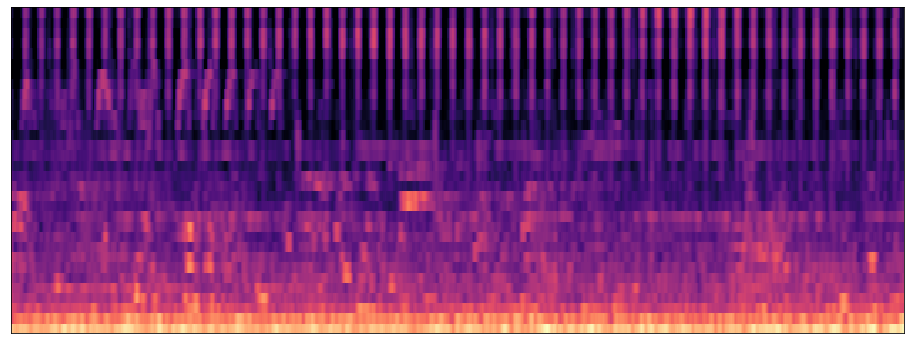

In [3]:
windowms = 64
hop_size = 1/4
hop = int(np.round(rate * windowms / (2000) * hop_size)*2)
melspectogram = librosa.feature.melspectrogram(audio, sr= rate, n_fft= hop * 8, hop_length= hop, power = 4, n_mels=32)
melSpec_dB = librosa.power_to_db(melspectogram, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(melSpec_dB)

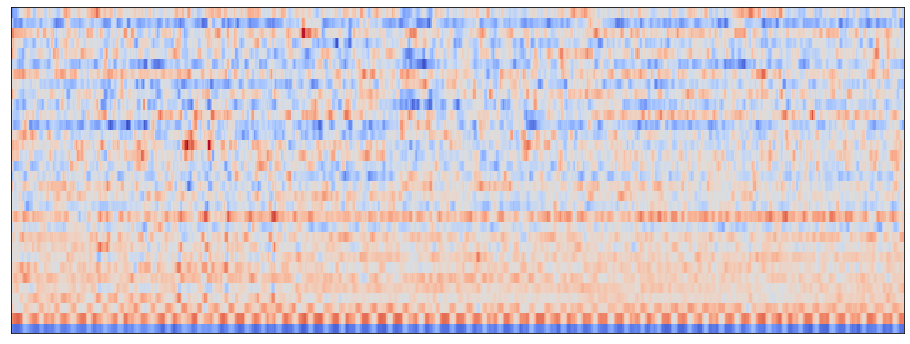

In [55]:
cepstogram = librosa.feature.mfcc(audio, sr = rate,n_mfcc = 32, hop_length= hop, lifter=60)
plt.figure(figsize=(16, 6))
librosa.display.specshow(cepstogram)

In [273]:
cepstogram.shape

(32, 627)

<ipython-input-248-48d3add09869>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta, residual, _, _ = np.linalg.lstsq(H, z)


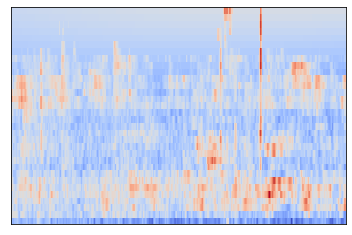

In [248]:
X, Y = np.meshgrid(range(melSpec_dB.shape[1]), range(melSpec_dB.shape[0]))
Z = melSpec_dB

x = X.ravel()
y = Y.ravel()
z = Z.ravel()

H = np.column_stack([
    x**2,
    y**2,
    x * y,
    x,
    y,
    np.ones_like(x)
])
theta, residual, _, _ = np.linalg.lstsq(H, z)
# Predict
z_pred = H @ theta
Z_pred = np.reshape(z_pred, X.shape)

# Subtract & show
S = Z - Z_pred
librosa.display.specshow(S)


In [284]:
np.array(ff1010bird_joint).shape

(20, 32, 627, 2)

Sound 1 preprocessed
Sound 2 preprocessed
Sound 3 preprocessed
Sound 4 preprocessed
Sound 5 preprocessed
Sound 6 preprocessed
Sound 7 preprocessed
Execution time for ff1010bird_1 preprocessing 3.2139995098114014 seconds
ff1010bird_1 saved to ./data/preprocessed/


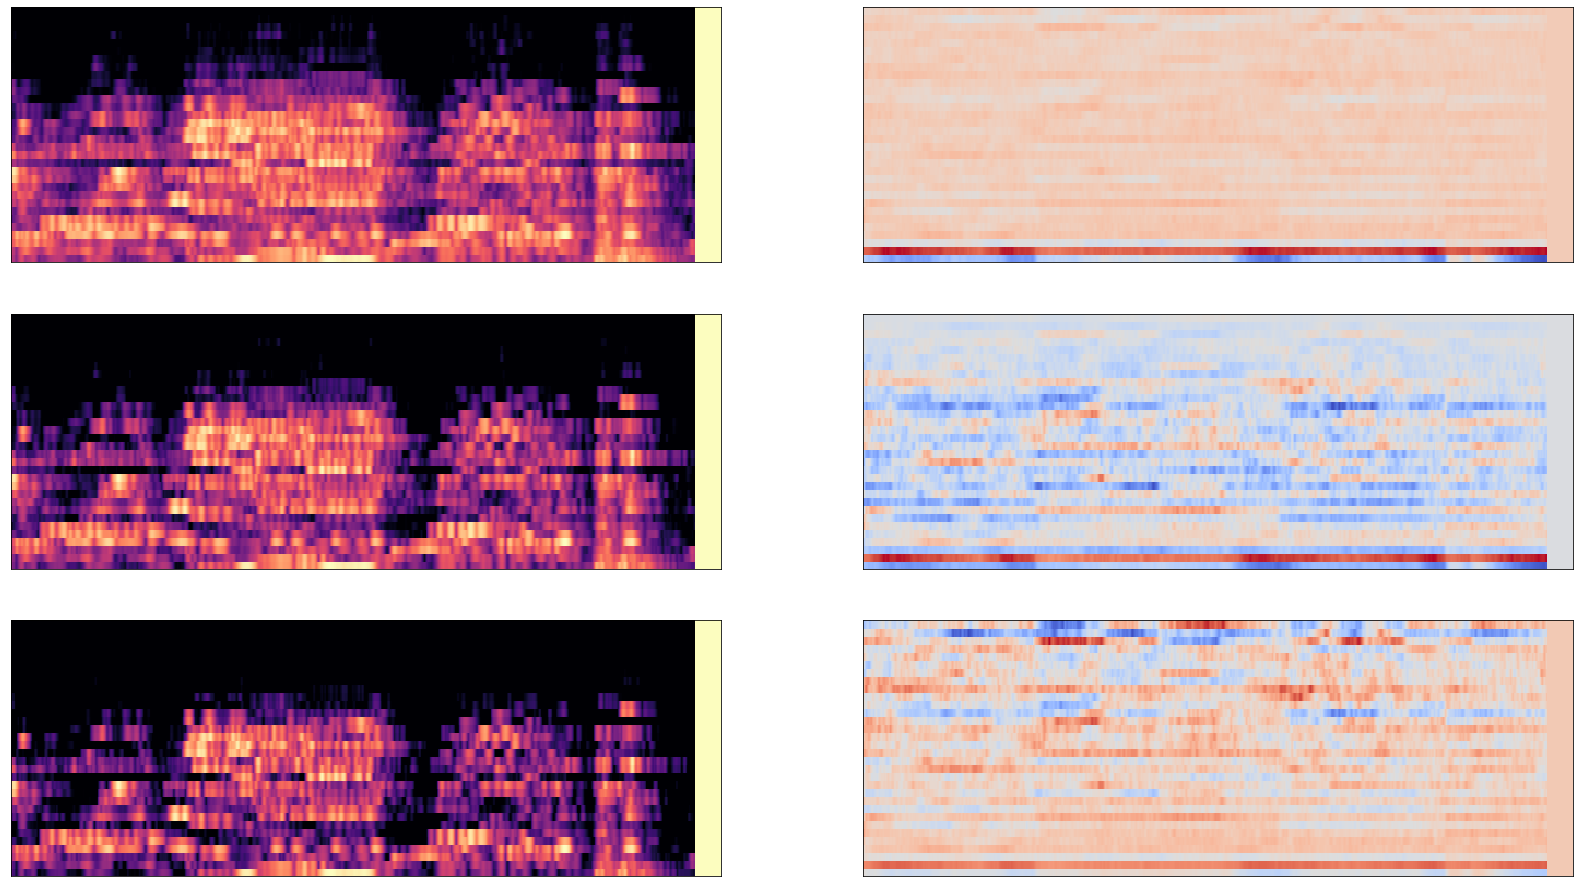

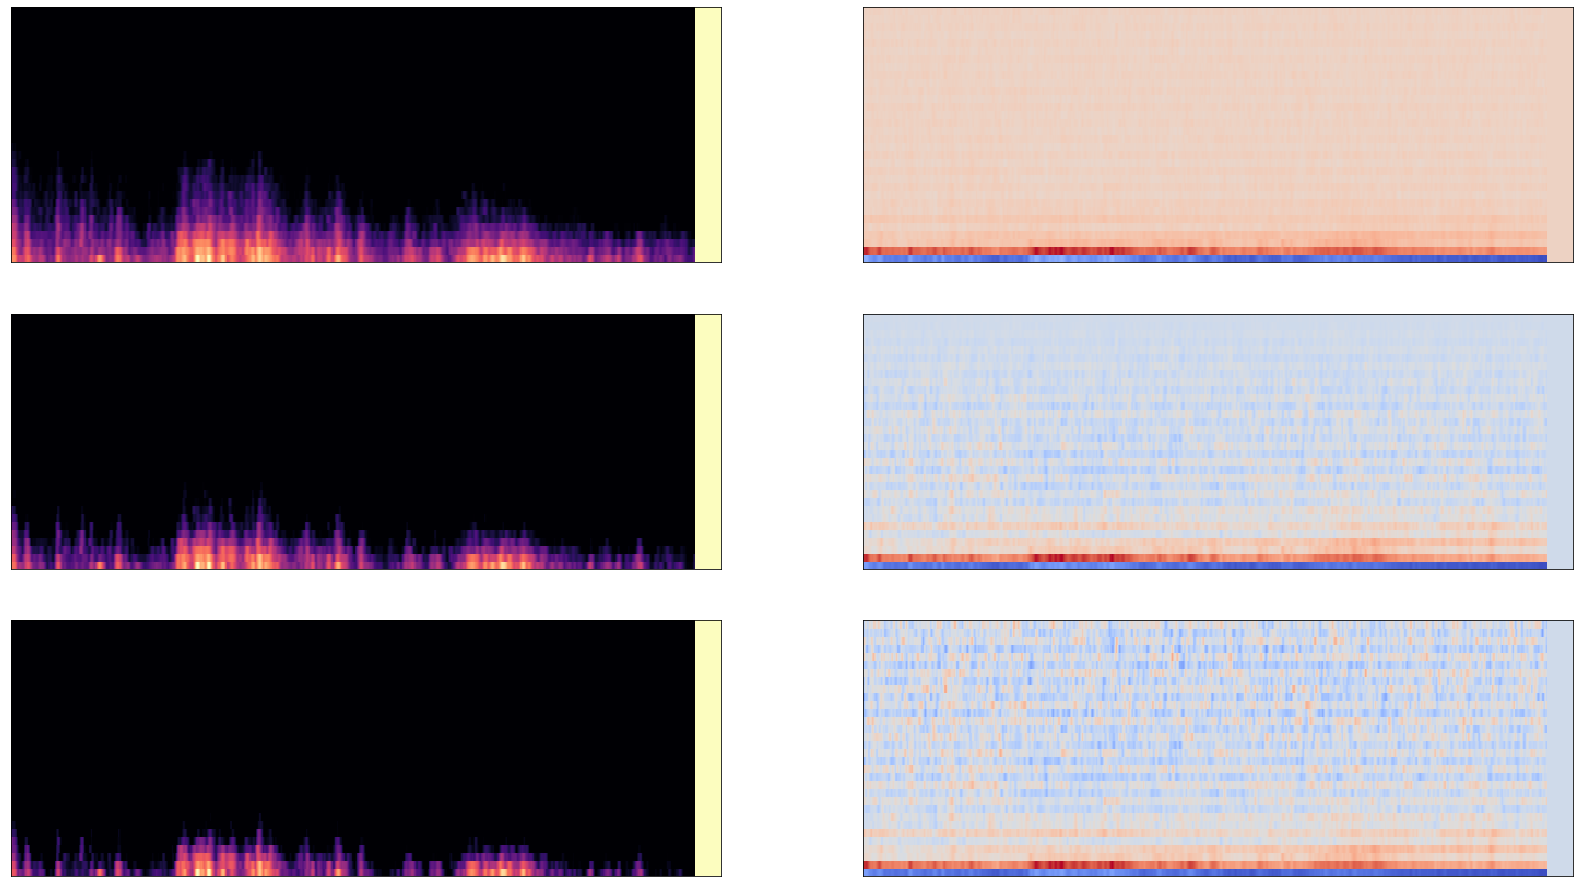

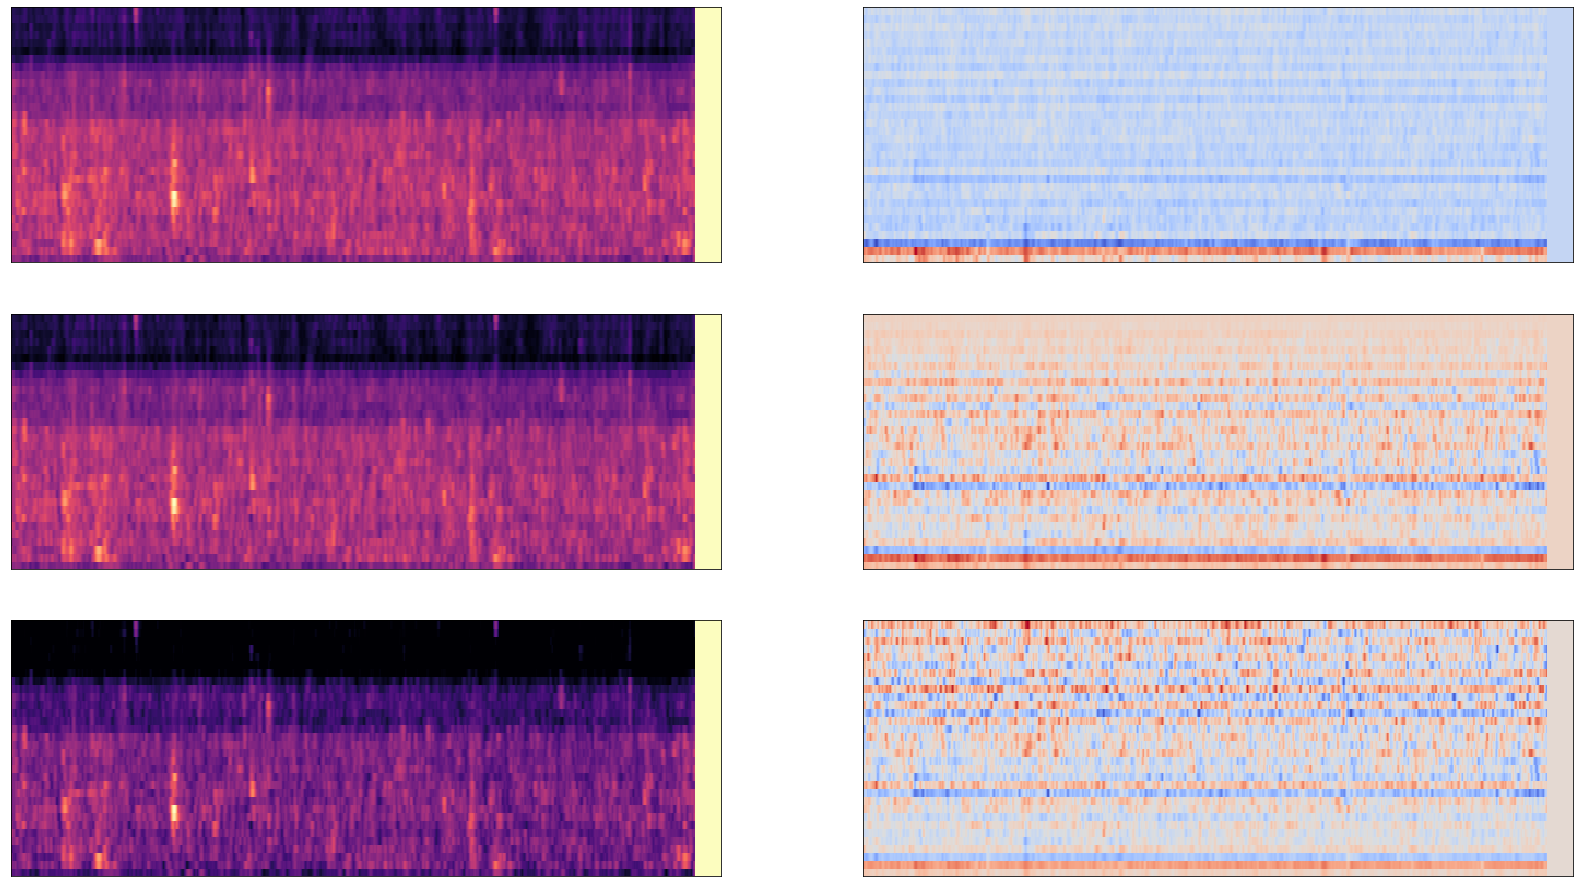

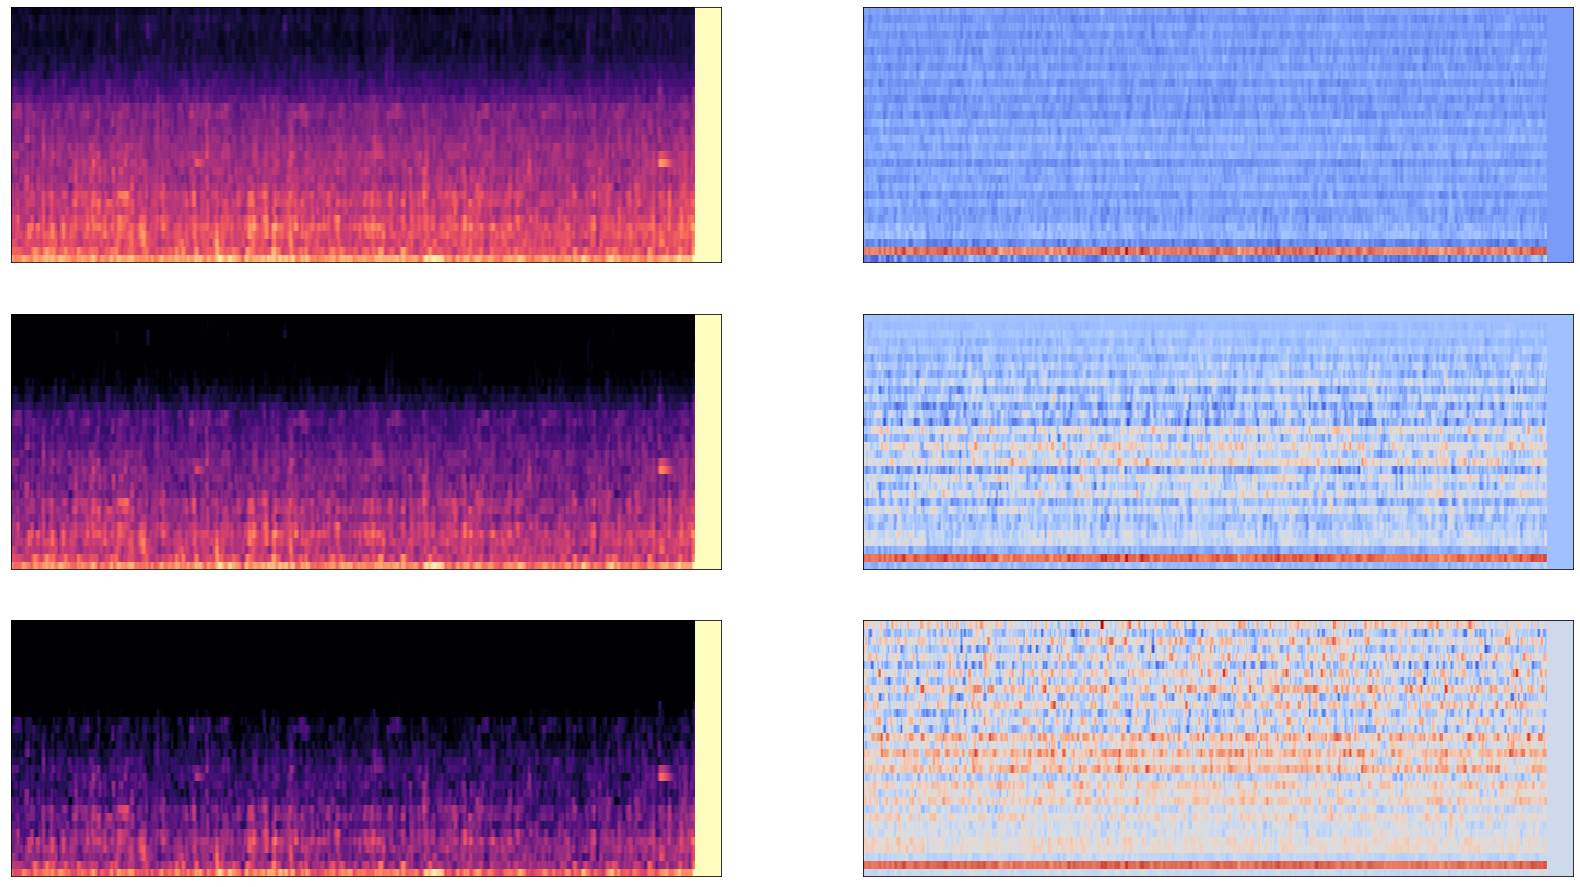

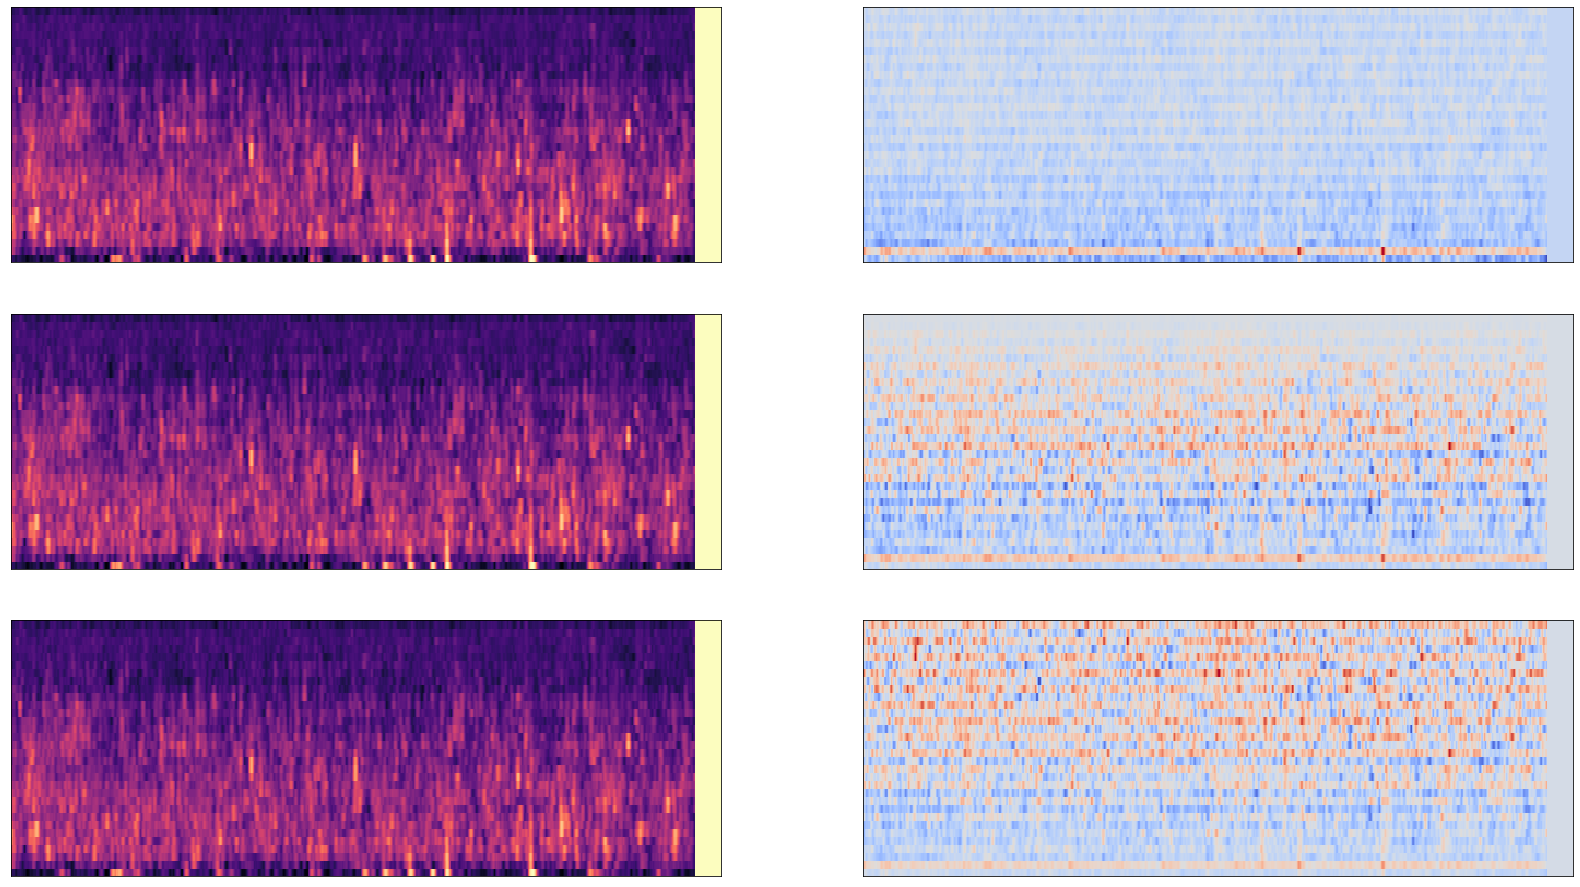

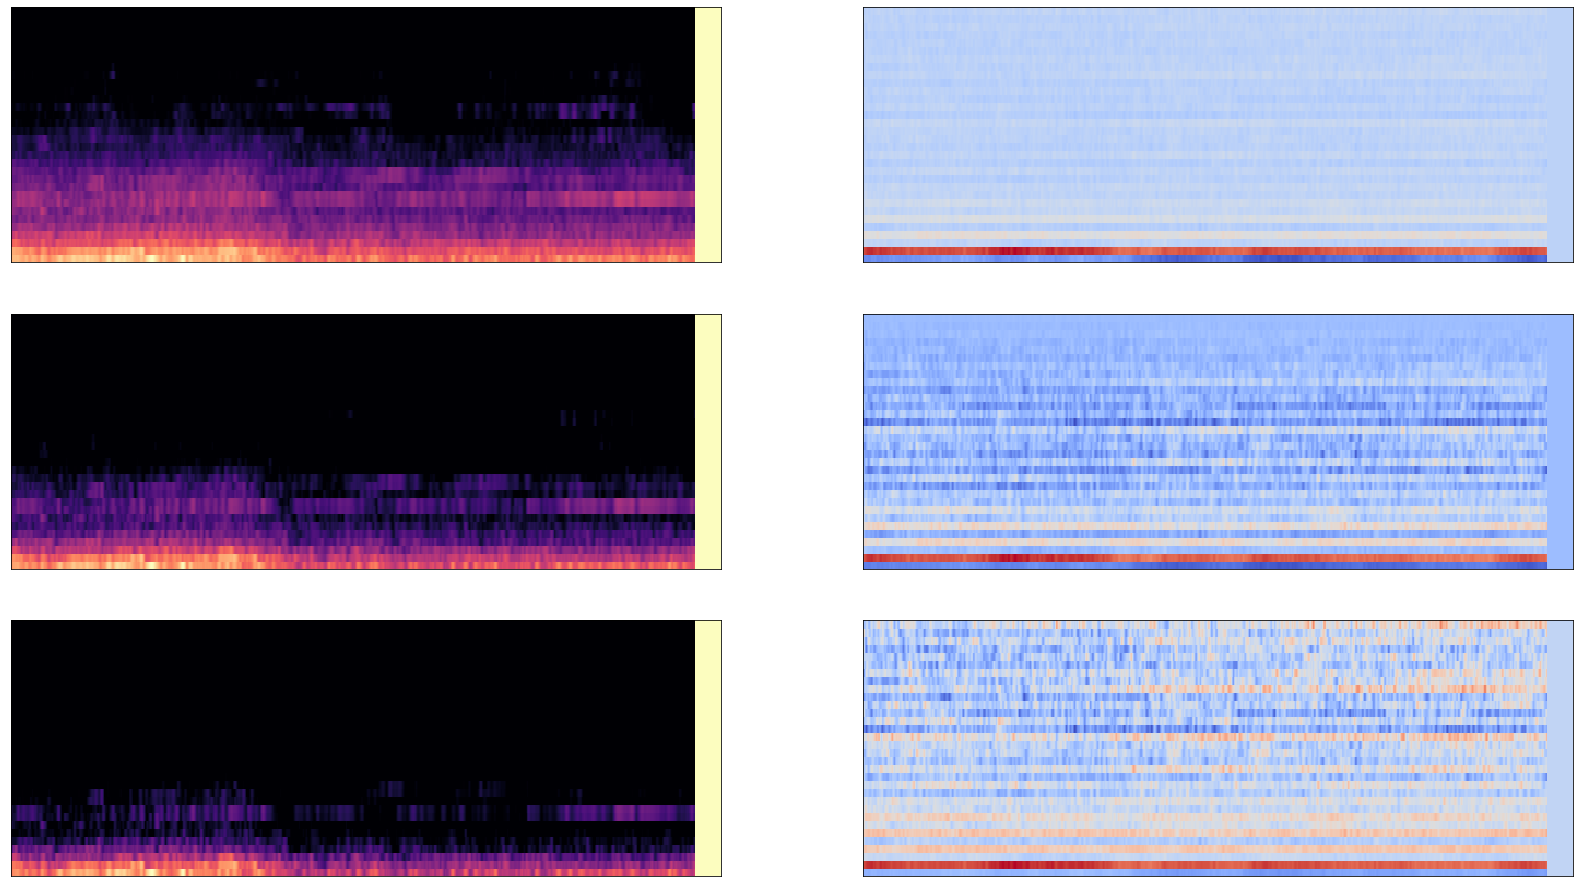

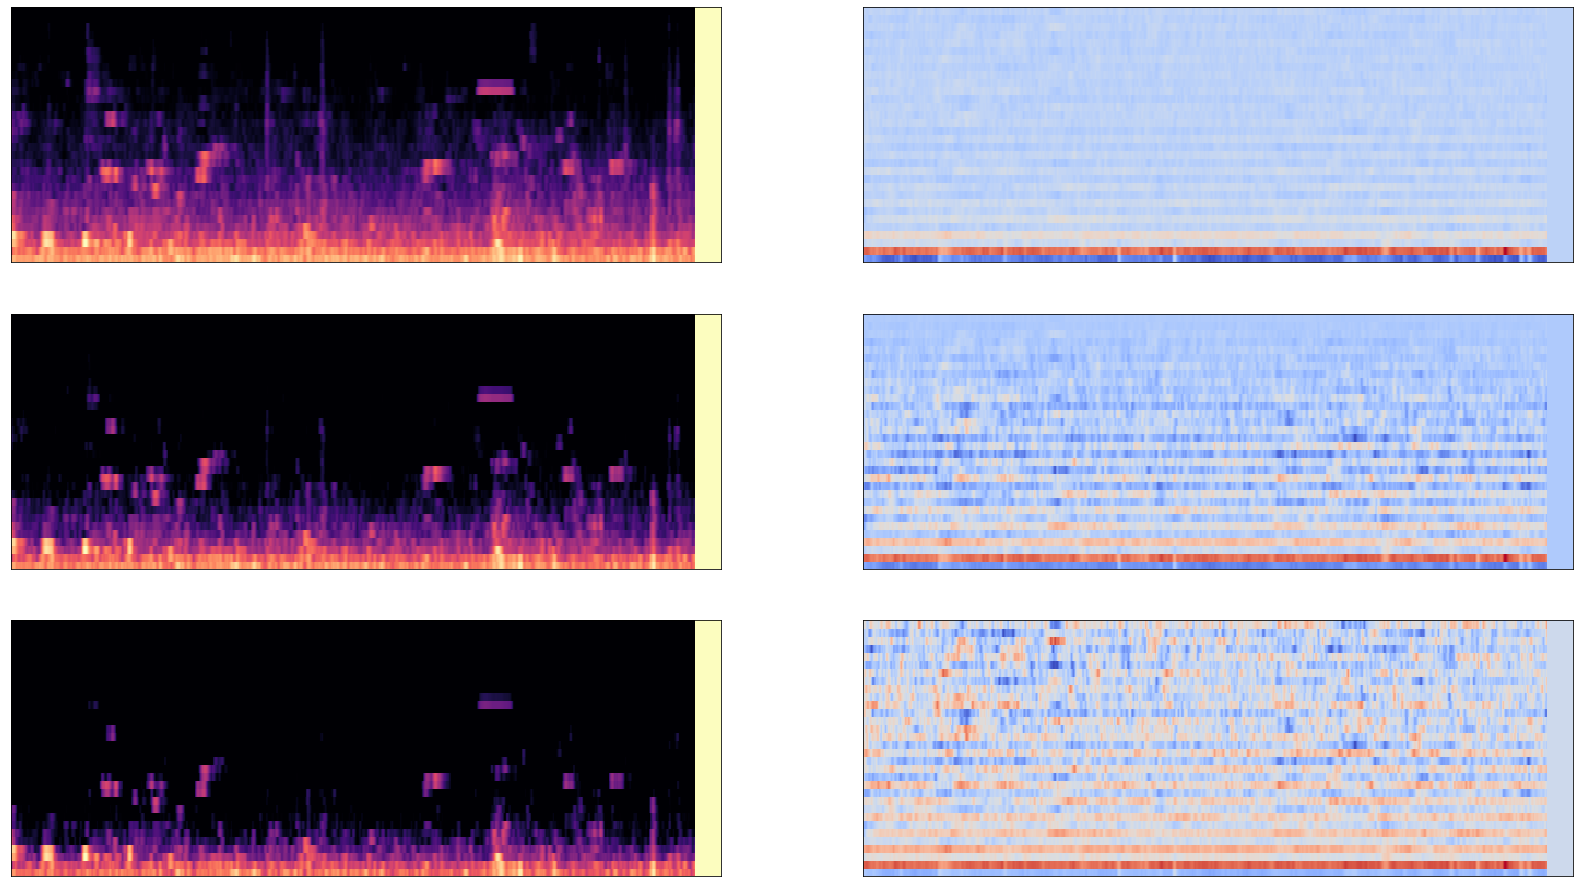

In [83]:
import librosa
import librosa.display
import os
import numpy as np
import matplotlib.pyplot as plt
import time

def make_uniform(array, lenght):
    if array.shape[1] < lenght:
        missing = lenght - array.shape[1]
        new_array = np.pad(array, ((0, 0), (0, missing)), 'constant', constant_values=(0,0))
    elif array.shape[1] > lenght:
        new_array = array[: , :lenght]
    elif array.shape[1] == lenght:
        new_array = array
    return new_array
            
def preprocess_dateset(dataset_name, path, labels, pad_to = 650):
    target_sample_rate = 22050
    windowms = 64
    hop_size = 1/4
    freq_bins = 32
    specs = []
    mfcc = []
    joint = []
    i = 1
    start = time.time()
    for filename, _, label in labels[:7]:
        audio, rate = librosa.load(path + filename + '.wav')
        audio = librosa.resample(audio, rate, target_sample_rate)
        rate = target_sample_rate
        
        audio = audio * 1/np.abs(np.max(audio))
        
        hop = int(np.round(rate * windowms / (2000) * hop_size)*2)  
        
        melSpec_dB=[]
        cepstogram=[]
        for j in range(3):
            melspectogram = librosa.feature.melspectrogram(audio, sr= rate, n_fft= hop * 8, hop_length= hop, power = 4 + j, n_mels=freq_bins)
            melSpec_dB_unit = librosa.power_to_db(melspectogram, ref=np.max)
            melSpec_dB.append(make_uniform(melSpec_dB_unit, lenght=pad_to))
            
            cepstogram_unit = librosa.feature.mfcc(audio, sr = rate, n_mfcc = freq_bins, hop_length= hop, lifter=j * freq_bins)
            cepstogram.append(make_uniform(cepstogram_unit, lenght=pad_to))
           
        fig, ax = plt.subplots(3, 2, figsize=(28, 16))
        img1 = librosa.display.specshow(melSpec_dB[0], ax=ax[0,0])
        img2 = librosa.display.specshow(melSpec_dB[1], ax=ax[1,0])
        img3 = librosa.display.specshow(melSpec_dB[2], ax=ax[2,0])
        img4 = librosa.display.specshow(cepstogram[0], ax=ax[0,1])
        img5 = librosa.display.specshow(cepstogram[1], ax=ax[1,1])
        img6 = librosa.display.specshow(cepstogram[2], ax=ax[2,1])
        
        specs.append(melSpec_dB)
        mfcc.append(cepstogram)
        joint.append(np.array([melSpec_dB, cepstogram]).reshape([freq_bins, pad_to, 6]))
        print(f'Sound {i} preprocessed')
        i = i + 1
        
    np.save('./data/preprocessed/' + dataset_name + '_specs', np.array(specs), allow_pickle=True)
    np.save('./data/preprocessed/' + dataset_name + '_mfcc', np.array(mfcc), allow_pickle=True)
    np.save('./data/preprocessed/' + dataset_name + '_joint', np.array(joint), allow_pickle=True)
    np.save('./data/preprocessed/' + dataset_name + '_labels', labels[:,2])
    print(f'Execution time for {dataset_name} preprocessing {time.time() - start} seconds')
    print(f'{dataset_name} saved to ./data/preprocessed/')
    
    return None



split_to = 10 # In how many parts should the dataset be handled

ff1010bird_labels = np.loadtxt('./data/ff1010bird_metadata_2018.csv', dtype=str, delimiter=',', skiprows=1)
for i in range(1):
    start_idx = int(np.round(ff1010bird_labels.shape[0] / split_to) * i)
    end_idx = int(np.round(ff1010bird_labels.shape[0] / split_to) * (i + 1) - 1)
    spec_test = preprocess_dateset(dataset_name = 'ff1010bird_' + str(i+1), path = './data/ff1010bird_wav/wav/', labels = ff1010bird_labels[start_idx:end_idx])

#warblrb10k_public_labels = np.loadtxt('./data/warblrb10k_public_metadata_2018.csv', dtype=str, delimiter=',', skiprows=1)
#for i in range(split_to):
#    start_idx = int(np.round(warblrb10k_public_labels.shape[0] / split_to) * i)
#    end_idx = int(np.round(warblrb10k_public_labels.shape[0] / split_to) * (i + 1) - 1)
#    preprocess_dateset(dataset_name = 'warblrb10k_public_' + str(i+1), path = './data/warblrb10k_public_wav/wav/', labels = warblrb10k_public_labels[start_idx:end_idx])



In [88]:
import librosa
import librosa.display
import os
import numpy as np
import matplotlib.pyplot as plt
import time

def make_uniform(array, lenght):
    if array.shape[1] < lenght:
        missing = lenght - array.shape[1]
        new_array = np.pad(array, ((0, 0), (0, missing)), 'constant', constant_values=(0,0))
    elif array.shape[1] > lenght:
        new_array = array[: , :lenght]
    elif array.shape[1] == lenght:
        new_array = array
    return new_array
            
def preprocess_dateset(dataset_name, path, labels, pad_to = 650):
    target_sample_rate = 22050
    windowms = 64
    hop_size = 1/4
    freq_bins = 32
    specs = []
    mfcc = []
    joint = []
    i = 1
    start = time.time()
    for filename, _, label in labels[:12]:
        audio, rate = librosa.load(path + filename + '.wav')
        audio = librosa.resample(audio, rate, target_sample_rate)
        rate = target_sample_rate
        
        audio = audio * 1/np.abs(np.max(audio))
        
        hop = int(np.round(rate * windowms / (2000) * hop_size)*2)  
        
        melSpec_dB=[]
        cepstogram=[]
        for j in range(3):
            melspectogram = librosa.feature.melspectrogram(audio, sr= rate, n_fft= hop * 8, hop_length= hop, power = 4 + j, n_mels=freq_bins)
            melSpec_dB_unit = librosa.power_to_db(melspectogram, ref=np.max)
            melSpec_dB.append(make_uniform(melSpec_dB_unit, lenght=pad_to))
            
            cepstogram_unit = librosa.feature.mfcc(audio, sr = rate, n_mfcc = freq_bins, hop_length= hop, lifter=j * freq_bins)
            cepstogram.append(make_uniform(cepstogram_unit, lenght=pad_to))
        
        specs.append(melSpec_dB)
        mfcc.append(cepstogram)
        joint.append(np.array([melSpec_dB, cepstogram]).reshape([freq_bins, pad_to, 6]))
        print(f'Sound {i} preprocessed')
        i = i + 1
        
    np.save('./data/preprocessed/' + dataset_name + '_specs', np.array(specs), allow_pickle=True)
    np.save('./data/preprocessed/' + dataset_name + '_mfcc', np.array(mfcc), allow_pickle=True)
    np.save('./data/preprocessed/' + dataset_name + '_joint', np.array(joint), allow_pickle=True)
    np.save('./data/preprocessed/' + dataset_name + '_labels', labels[:,2])
    print(f'Execution time for {dataset_name} preprocessing {time.time() - start} seconds')
    print(f'{dataset_name} saved to ./data/preprocessed/')
    
    return None

split_to = 10 # In how many parts should the dataset be handled

ff1010bird_labels = np.loadtxt('./data/ff1010bird_metadata_2018.csv', dtype=str, delimiter=',', skiprows=1)
for i in range(1):
    start_idx = int(np.round(ff1010bird_labels.shape[0] / split_to) * i)
    end_idx = int(np.round(ff1010bird_labels.shape[0] / split_to) * (i + 1) - 1)
    spec_test = preprocess_dateset(dataset_name = 'ff1010bird_' + str(i+1), path = './data/ff1010bird_wav/wav/', labels = ff1010bird_labels[start_idx:end_idx])

#warblrb10k_public_labels = np.loadtxt('./data/warblrb10k_public_metadata_2018.csv', dtype=str, delimiter=',', skiprows=1)
#for i in range(split_to):
#    start_idx = int(np.round(warblrb10k_public_labels.shape[0] / split_to) * i)
#    end_idx = int(np.round(warblrb10k_public_labels.shape[0] / split_to) * (i + 1) - 1)
#    preprocess_dateset(dataset_name = 'warblrb10k_public_' + str(i+1), path = './data/warblrb10k_public_wav/wav/', labels = warblrb10k_public_labels[start_idx:end_idx])



Sound 1 preprocessed
Sound 2 preprocessed
Sound 3 preprocessed
Sound 4 preprocessed
Sound 5 preprocessed
Sound 6 preprocessed
Sound 7 preprocessed
Sound 8 preprocessed
Sound 9 preprocessed
Sound 10 preprocessed
Sound 11 preprocessed
Sound 12 preprocessed
Execution time for ff1010bird_1 preprocessing 4.467999458312988 seconds
ff1010bird_1 saved to ./data/preprocessed/


In [98]:
testset_paths = np.array(os.listdir('./data/audio_test'))
testset_paths = np.vstack((testset_paths, np.zeros(testset_paths.shape), np.zeros(testset_paths.shape))).T

In [99]:
testset_paths

array([['0.npy', '0.0', '0.0'],
       ['1.npy', '0.0', '0.0'],
       ['10.npy', '0.0', '0.0'],
       ...,
       ['997.npy', '0.0', '0.0'],
       ['998.npy', '0.0', '0.0'],
       ['999.npy', '0.0', '0.0']], dtype='<U32')

In [85]:
spec_test[6,0].sum(),spec_test[6,1].sum(),spec_test[6,2].sum()

(-1268646.9, -1401020.2, -1464743.5)

In [23]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(cepstogram)

NameError: name 'cepstogram' is not defined

<Figure size 1152x432 with 0 Axes>